In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt


In [2]:
class OneLayerNet(nn.Module):
    def __init__(self):
        super(OneLayerNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, 3, 1)
        self.fc1 = nn.Linear(676, 10)


    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
         
        x = torch.flatten(x, 1)
        x = self.fc1(x)

        output = F.log_softmax(x, dim=1)
        return output

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, 1)
        self.conv2 = nn.Conv2d(6, 16, 5, 1)
        self.fc1 = nn.Linear(256, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)


    def forward(self, x):
        x = self.conv1(x)
        x = torch.tanh(x)
        x = F.max_pool2d(x, 2)
        
        x = self.conv2(x)    
        x = torch.tanh(x)        
        x = F.max_pool2d(x, 2)
        
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = torch.tanh(x)
        x = self.fc2(x)
        x = torch.tanh(x)
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output
class LeNetRelu(nn.Module):
    def __init__(self):
        super(LeNetRelu, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, 1)
        self.conv2 = nn.Conv2d(6, 16, 5, 1)
        self.fc1 = nn.Linear(256, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)


    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.conv2(x)    
        x = F.relu(x)        
        x = F.max_pool2d(x, 2)
        
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    


def test(model, device, test_loader,test_scores):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    test_scores.append(correct / len(test_loader.dataset))
    print('\nTest set: , Accuracy: {}/{} ({:.0f}%)\n'.format(
        correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return pred




args = {'batch-size':64, 'test-batch-size':1000,'epochs':20,'lr':1.0,'gamma':0.7,'no_cuda':False,
       'dry_run':False,'seed':1,'log_interval':10,'save_model':False}

torch.manual_seed(1)

device = torch.device("cuda")

train_kwargs = {'batch_size': 64,'shuffle':True}
test_kwargs = {'batch_size': 10000, 'shuffle':False}


transform=transforms.Compose([ transforms.ToTensor(),])
dataset1 = datasets.MNIST('data', train=True, transform=transform)
dataset2 = datasets.MNIST('data', train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)





In [7]:
test_scores = []
models = [OneLayerNet(),LeNet(),LeNetRelu(),Net()]
for n_model in models:
    test_scores.append([])
    model = n_model.to(device)
    optimizer = optim.Adadelta(model.parameters())
    scheduler = StepLR(optimizer, step_size=1)
    for epoch in range(1, 10):
        train(args, model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader,test_scores[-1])
        scheduler.step()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303520
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.279158
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.140716
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.860687
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.748901
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.719553
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.689264
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.629666
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.580702
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.629708
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.666003
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.633168
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.605496
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.612341
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.591437
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.615744
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.653430
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.556436
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.658409
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.650512
Train Epoch: 1 [12800/60000 (

Train Epoch: 2 [45440/60000 (76%)]	Loss: 1.483493
Train Epoch: 2 [46080/60000 (77%)]	Loss: 1.586205
Train Epoch: 2 [46720/60000 (78%)]	Loss: 1.502620
Train Epoch: 2 [47360/60000 (79%)]	Loss: 1.500446
Train Epoch: 2 [48000/60000 (80%)]	Loss: 1.556831
Train Epoch: 2 [48640/60000 (81%)]	Loss: 1.542823
Train Epoch: 2 [49280/60000 (82%)]	Loss: 1.590757
Train Epoch: 2 [49920/60000 (83%)]	Loss: 1.511537
Train Epoch: 2 [50560/60000 (84%)]	Loss: 1.542296
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.500023
Train Epoch: 2 [51840/60000 (86%)]	Loss: 1.582371
Train Epoch: 2 [52480/60000 (87%)]	Loss: 1.556480
Train Epoch: 2 [53120/60000 (88%)]	Loss: 1.507553
Train Epoch: 2 [53760/60000 (90%)]	Loss: 1.579355
Train Epoch: 2 [54400/60000 (91%)]	Loss: 1.531395
Train Epoch: 2 [55040/60000 (92%)]	Loss: 1.633400
Train Epoch: 2 [55680/60000 (93%)]	Loss: 1.529256
Train Epoch: 2 [56320/60000 (94%)]	Loss: 1.506575
Train Epoch: 2 [56960/60000 (95%)]	Loss: 1.495524
Train Epoch: 2 [57600/60000 (96%)]	Loss: 1.517721


Train Epoch: 4 [30720/60000 (51%)]	Loss: 1.560226
Train Epoch: 4 [31360/60000 (52%)]	Loss: 1.546073
Train Epoch: 4 [32000/60000 (53%)]	Loss: 1.550282
Train Epoch: 4 [32640/60000 (54%)]	Loss: 1.523320
Train Epoch: 4 [33280/60000 (55%)]	Loss: 1.520779
Train Epoch: 4 [33920/60000 (57%)]	Loss: 1.519529
Train Epoch: 4 [34560/60000 (58%)]	Loss: 1.576102
Train Epoch: 4 [35200/60000 (59%)]	Loss: 1.541102
Train Epoch: 4 [35840/60000 (60%)]	Loss: 1.545625
Train Epoch: 4 [36480/60000 (61%)]	Loss: 1.592737
Train Epoch: 4 [37120/60000 (62%)]	Loss: 1.524418
Train Epoch: 4 [37760/60000 (63%)]	Loss: 1.609697
Train Epoch: 4 [38400/60000 (64%)]	Loss: 1.529995
Train Epoch: 4 [39040/60000 (65%)]	Loss: 1.532789
Train Epoch: 4 [39680/60000 (66%)]	Loss: 1.547036
Train Epoch: 4 [40320/60000 (67%)]	Loss: 1.572196
Train Epoch: 4 [40960/60000 (68%)]	Loss: 1.505281
Train Epoch: 4 [41600/60000 (69%)]	Loss: 1.480920
Train Epoch: 4 [42240/60000 (70%)]	Loss: 1.505145
Train Epoch: 4 [42880/60000 (71%)]	Loss: 1.579255


Train Epoch: 6 [16000/60000 (27%)]	Loss: 1.489101
Train Epoch: 6 [16640/60000 (28%)]	Loss: 1.507467
Train Epoch: 6 [17280/60000 (29%)]	Loss: 1.616298
Train Epoch: 6 [17920/60000 (30%)]	Loss: 1.543468
Train Epoch: 6 [18560/60000 (31%)]	Loss: 1.548448
Train Epoch: 6 [19200/60000 (32%)]	Loss: 1.526472
Train Epoch: 6 [19840/60000 (33%)]	Loss: 1.514353
Train Epoch: 6 [20480/60000 (34%)]	Loss: 1.528557
Train Epoch: 6 [21120/60000 (35%)]	Loss: 1.549262
Train Epoch: 6 [21760/60000 (36%)]	Loss: 1.510642
Train Epoch: 6 [22400/60000 (37%)]	Loss: 1.483446
Train Epoch: 6 [23040/60000 (38%)]	Loss: 1.542702
Train Epoch: 6 [23680/60000 (39%)]	Loss: 1.546313
Train Epoch: 6 [24320/60000 (41%)]	Loss: 1.508694
Train Epoch: 6 [24960/60000 (42%)]	Loss: 1.500568
Train Epoch: 6 [25600/60000 (43%)]	Loss: 1.539047
Train Epoch: 6 [26240/60000 (44%)]	Loss: 1.540342
Train Epoch: 6 [26880/60000 (45%)]	Loss: 1.549532
Train Epoch: 6 [27520/60000 (46%)]	Loss: 1.525539
Train Epoch: 6 [28160/60000 (47%)]	Loss: 1.560807


Train Epoch: 8 [1280/60000 (2%)]	Loss: 1.508198
Train Epoch: 8 [1920/60000 (3%)]	Loss: 1.557027
Train Epoch: 8 [2560/60000 (4%)]	Loss: 1.546531
Train Epoch: 8 [3200/60000 (5%)]	Loss: 1.567079
Train Epoch: 8 [3840/60000 (6%)]	Loss: 1.541247
Train Epoch: 8 [4480/60000 (7%)]	Loss: 1.543798
Train Epoch: 8 [5120/60000 (9%)]	Loss: 1.546686
Train Epoch: 8 [5760/60000 (10%)]	Loss: 1.564719
Train Epoch: 8 [6400/60000 (11%)]	Loss: 1.553199
Train Epoch: 8 [7040/60000 (12%)]	Loss: 1.503130
Train Epoch: 8 [7680/60000 (13%)]	Loss: 1.508595
Train Epoch: 8 [8320/60000 (14%)]	Loss: 1.538195
Train Epoch: 8 [8960/60000 (15%)]	Loss: 1.575912
Train Epoch: 8 [9600/60000 (16%)]	Loss: 1.560426
Train Epoch: 8 [10240/60000 (17%)]	Loss: 1.539447
Train Epoch: 8 [10880/60000 (18%)]	Loss: 1.557112
Train Epoch: 8 [11520/60000 (19%)]	Loss: 1.557545
Train Epoch: 8 [12160/60000 (20%)]	Loss: 1.544734
Train Epoch: 8 [12800/60000 (21%)]	Loss: 1.524852
Train Epoch: 8 [13440/60000 (22%)]	Loss: 1.533997
Train Epoch: 8 [14080

Train Epoch: 9 [46720/60000 (78%)]	Loss: 1.556624
Train Epoch: 9 [47360/60000 (79%)]	Loss: 1.530994
Train Epoch: 9 [48000/60000 (80%)]	Loss: 1.559245
Train Epoch: 9 [48640/60000 (81%)]	Loss: 1.482182
Train Epoch: 9 [49280/60000 (82%)]	Loss: 1.552690
Train Epoch: 9 [49920/60000 (83%)]	Loss: 1.479615
Train Epoch: 9 [50560/60000 (84%)]	Loss: 1.616239
Train Epoch: 9 [51200/60000 (85%)]	Loss: 1.560896
Train Epoch: 9 [51840/60000 (86%)]	Loss: 1.507303
Train Epoch: 9 [52480/60000 (87%)]	Loss: 1.573795
Train Epoch: 9 [53120/60000 (88%)]	Loss: 1.598708
Train Epoch: 9 [53760/60000 (90%)]	Loss: 1.523659
Train Epoch: 9 [54400/60000 (91%)]	Loss: 1.556224
Train Epoch: 9 [55040/60000 (92%)]	Loss: 1.543069
Train Epoch: 9 [55680/60000 (93%)]	Loss: 1.538008
Train Epoch: 9 [56320/60000 (94%)]	Loss: 1.499159
Train Epoch: 9 [56960/60000 (95%)]	Loss: 1.566186
Train Epoch: 9 [57600/60000 (96%)]	Loss: 1.553076
Train Epoch: 9 [58240/60000 (97%)]	Loss: 1.571805
Train Epoch: 9 [58880/60000 (98%)]	Loss: 1.492718


Train Epoch: 2 [31360/60000 (52%)]	Loss: 1.497411
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.465894
Train Epoch: 2 [32640/60000 (54%)]	Loss: 1.486986
Train Epoch: 2 [33280/60000 (55%)]	Loss: 1.501967
Train Epoch: 2 [33920/60000 (57%)]	Loss: 1.482419
Train Epoch: 2 [34560/60000 (58%)]	Loss: 1.489375
Train Epoch: 2 [35200/60000 (59%)]	Loss: 1.477348
Train Epoch: 2 [35840/60000 (60%)]	Loss: 1.473085
Train Epoch: 2 [36480/60000 (61%)]	Loss: 1.479453
Train Epoch: 2 [37120/60000 (62%)]	Loss: 1.474720
Train Epoch: 2 [37760/60000 (63%)]	Loss: 1.474336
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.501559
Train Epoch: 2 [39040/60000 (65%)]	Loss: 1.524326
Train Epoch: 2 [39680/60000 (66%)]	Loss: 1.492290
Train Epoch: 2 [40320/60000 (67%)]	Loss: 1.469671
Train Epoch: 2 [40960/60000 (68%)]	Loss: 1.468132
Train Epoch: 2 [41600/60000 (69%)]	Loss: 1.469519
Train Epoch: 2 [42240/60000 (70%)]	Loss: 1.498532
Train Epoch: 2 [42880/60000 (71%)]	Loss: 1.480283
Train Epoch: 2 [43520/60000 (72%)]	Loss: 1.490001


Train Epoch: 4 [16000/60000 (27%)]	Loss: 1.465206
Train Epoch: 4 [16640/60000 (28%)]	Loss: 1.469274
Train Epoch: 4 [17280/60000 (29%)]	Loss: 1.497430
Train Epoch: 4 [17920/60000 (30%)]	Loss: 1.503360
Train Epoch: 4 [18560/60000 (31%)]	Loss: 1.504529
Train Epoch: 4 [19200/60000 (32%)]	Loss: 1.467853
Train Epoch: 4 [19840/60000 (33%)]	Loss: 1.473502
Train Epoch: 4 [20480/60000 (34%)]	Loss: 1.532152
Train Epoch: 4 [21120/60000 (35%)]	Loss: 1.510909
Train Epoch: 4 [21760/60000 (36%)]	Loss: 1.487976
Train Epoch: 4 [22400/60000 (37%)]	Loss: 1.497967
Train Epoch: 4 [23040/60000 (38%)]	Loss: 1.481828
Train Epoch: 4 [23680/60000 (39%)]	Loss: 1.478829
Train Epoch: 4 [24320/60000 (41%)]	Loss: 1.499285
Train Epoch: 4 [24960/60000 (42%)]	Loss: 1.489874
Train Epoch: 4 [25600/60000 (43%)]	Loss: 1.461830
Train Epoch: 4 [26240/60000 (44%)]	Loss: 1.492557
Train Epoch: 4 [26880/60000 (45%)]	Loss: 1.486051
Train Epoch: 4 [27520/60000 (46%)]	Loss: 1.478619
Train Epoch: 4 [28160/60000 (47%)]	Loss: 1.465126


Train Epoch: 6 [640/60000 (1%)]	Loss: 1.471266
Train Epoch: 6 [1280/60000 (2%)]	Loss: 1.482205
Train Epoch: 6 [1920/60000 (3%)]	Loss: 1.476519
Train Epoch: 6 [2560/60000 (4%)]	Loss: 1.492278
Train Epoch: 6 [3200/60000 (5%)]	Loss: 1.491215
Train Epoch: 6 [3840/60000 (6%)]	Loss: 1.509016
Train Epoch: 6 [4480/60000 (7%)]	Loss: 1.463384
Train Epoch: 6 [5120/60000 (9%)]	Loss: 1.494847
Train Epoch: 6 [5760/60000 (10%)]	Loss: 1.478388
Train Epoch: 6 [6400/60000 (11%)]	Loss: 1.483232
Train Epoch: 6 [7040/60000 (12%)]	Loss: 1.527846
Train Epoch: 6 [7680/60000 (13%)]	Loss: 1.463361
Train Epoch: 6 [8320/60000 (14%)]	Loss: 1.463134
Train Epoch: 6 [8960/60000 (15%)]	Loss: 1.501150
Train Epoch: 6 [9600/60000 (16%)]	Loss: 1.495515
Train Epoch: 6 [10240/60000 (17%)]	Loss: 1.483585
Train Epoch: 6 [10880/60000 (18%)]	Loss: 1.465693
Train Epoch: 6 [11520/60000 (19%)]	Loss: 1.494682
Train Epoch: 6 [12160/60000 (20%)]	Loss: 1.468982
Train Epoch: 6 [12800/60000 (21%)]	Loss: 1.479256
Train Epoch: 6 [13440/60

Train Epoch: 7 [46720/60000 (78%)]	Loss: 1.508634
Train Epoch: 7 [47360/60000 (79%)]	Loss: 1.504628
Train Epoch: 7 [48000/60000 (80%)]	Loss: 1.488538
Train Epoch: 7 [48640/60000 (81%)]	Loss: 1.491837
Train Epoch: 7 [49280/60000 (82%)]	Loss: 1.478563
Train Epoch: 7 [49920/60000 (83%)]	Loss: 1.462131
Train Epoch: 7 [50560/60000 (84%)]	Loss: 1.462239
Train Epoch: 7 [51200/60000 (85%)]	Loss: 1.468285
Train Epoch: 7 [51840/60000 (86%)]	Loss: 1.495577
Train Epoch: 7 [52480/60000 (87%)]	Loss: 1.493215
Train Epoch: 7 [53120/60000 (88%)]	Loss: 1.483514
Train Epoch: 7 [53760/60000 (90%)]	Loss: 1.468563
Train Epoch: 7 [54400/60000 (91%)]	Loss: 1.477689
Train Epoch: 7 [55040/60000 (92%)]	Loss: 1.462966
Train Epoch: 7 [55680/60000 (93%)]	Loss: 1.497048
Train Epoch: 7 [56320/60000 (94%)]	Loss: 1.477650
Train Epoch: 7 [56960/60000 (95%)]	Loss: 1.465998
Train Epoch: 7 [57600/60000 (96%)]	Loss: 1.464710
Train Epoch: 7 [58240/60000 (97%)]	Loss: 1.469308
Train Epoch: 7 [58880/60000 (98%)]	Loss: 1.514229


Train Epoch: 9 [31360/60000 (52%)]	Loss: 1.464297
Train Epoch: 9 [32000/60000 (53%)]	Loss: 1.488220
Train Epoch: 9 [32640/60000 (54%)]	Loss: 1.492227
Train Epoch: 9 [33280/60000 (55%)]	Loss: 1.479176
Train Epoch: 9 [33920/60000 (57%)]	Loss: 1.472765
Train Epoch: 9 [34560/60000 (58%)]	Loss: 1.466353
Train Epoch: 9 [35200/60000 (59%)]	Loss: 1.473499
Train Epoch: 9 [35840/60000 (60%)]	Loss: 1.501653
Train Epoch: 9 [36480/60000 (61%)]	Loss: 1.499890
Train Epoch: 9 [37120/60000 (62%)]	Loss: 1.506643
Train Epoch: 9 [37760/60000 (63%)]	Loss: 1.464308
Train Epoch: 9 [38400/60000 (64%)]	Loss: 1.488517
Train Epoch: 9 [39040/60000 (65%)]	Loss: 1.515135
Train Epoch: 9 [39680/60000 (66%)]	Loss: 1.520538
Train Epoch: 9 [40320/60000 (67%)]	Loss: 1.504924
Train Epoch: 9 [40960/60000 (68%)]	Loss: 1.476389
Train Epoch: 9 [41600/60000 (69%)]	Loss: 1.493463
Train Epoch: 9 [42240/60000 (70%)]	Loss: 1.466861
Train Epoch: 9 [42880/60000 (71%)]	Loss: 1.516415
Train Epoch: 9 [43520/60000 (72%)]	Loss: 1.484275


Train Epoch: 2 [16640/60000 (28%)]	Loss: 1.526515
Train Epoch: 2 [17280/60000 (29%)]	Loss: 1.541396
Train Epoch: 2 [17920/60000 (30%)]	Loss: 1.543681
Train Epoch: 2 [18560/60000 (31%)]	Loss: 1.476443
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.467837
Train Epoch: 2 [19840/60000 (33%)]	Loss: 1.496046
Train Epoch: 2 [20480/60000 (34%)]	Loss: 1.485704
Train Epoch: 2 [21120/60000 (35%)]	Loss: 1.508584
Train Epoch: 2 [21760/60000 (36%)]	Loss: 1.466368
Train Epoch: 2 [22400/60000 (37%)]	Loss: 1.461513
Train Epoch: 2 [23040/60000 (38%)]	Loss: 1.473891
Train Epoch: 2 [23680/60000 (39%)]	Loss: 1.461164
Train Epoch: 2 [24320/60000 (41%)]	Loss: 1.472837
Train Epoch: 2 [24960/60000 (42%)]	Loss: 1.495991
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.462018
Train Epoch: 2 [26240/60000 (44%)]	Loss: 1.496661
Train Epoch: 2 [26880/60000 (45%)]	Loss: 1.498917
Train Epoch: 2 [27520/60000 (46%)]	Loss: 1.468084
Train Epoch: 2 [28160/60000 (47%)]	Loss: 1.462701
Train Epoch: 2 [28800/60000 (48%)]	Loss: 1.492419


Train Epoch: 4 [640/60000 (1%)]	Loss: 1.514697
Train Epoch: 4 [1280/60000 (2%)]	Loss: 1.498654
Train Epoch: 4 [1920/60000 (3%)]	Loss: 1.468650
Train Epoch: 4 [2560/60000 (4%)]	Loss: 1.462683
Train Epoch: 4 [3200/60000 (5%)]	Loss: 1.494007
Train Epoch: 4 [3840/60000 (6%)]	Loss: 1.493201
Train Epoch: 4 [4480/60000 (7%)]	Loss: 1.491630
Train Epoch: 4 [5120/60000 (9%)]	Loss: 1.494604
Train Epoch: 4 [5760/60000 (10%)]	Loss: 1.476891
Train Epoch: 4 [6400/60000 (11%)]	Loss: 1.499313
Train Epoch: 4 [7040/60000 (12%)]	Loss: 1.474623
Train Epoch: 4 [7680/60000 (13%)]	Loss: 1.530680
Train Epoch: 4 [8320/60000 (14%)]	Loss: 1.484620
Train Epoch: 4 [8960/60000 (15%)]	Loss: 1.491691
Train Epoch: 4 [9600/60000 (16%)]	Loss: 1.482499
Train Epoch: 4 [10240/60000 (17%)]	Loss: 1.488791
Train Epoch: 4 [10880/60000 (18%)]	Loss: 1.497506
Train Epoch: 4 [11520/60000 (19%)]	Loss: 1.504414
Train Epoch: 4 [12160/60000 (20%)]	Loss: 1.474707
Train Epoch: 4 [12800/60000 (21%)]	Loss: 1.480007
Train Epoch: 4 [13440/60

Train Epoch: 5 [46720/60000 (78%)]	Loss: 1.508906
Train Epoch: 5 [47360/60000 (79%)]	Loss: 1.463279
Train Epoch: 5 [48000/60000 (80%)]	Loss: 1.508019
Train Epoch: 5 [48640/60000 (81%)]	Loss: 1.497296
Train Epoch: 5 [49280/60000 (82%)]	Loss: 1.469159
Train Epoch: 5 [49920/60000 (83%)]	Loss: 1.491847
Train Epoch: 5 [50560/60000 (84%)]	Loss: 1.463335
Train Epoch: 5 [51200/60000 (85%)]	Loss: 1.475787
Train Epoch: 5 [51840/60000 (86%)]	Loss: 1.513445
Train Epoch: 5 [52480/60000 (87%)]	Loss: 1.512356
Train Epoch: 5 [53120/60000 (88%)]	Loss: 1.461275
Train Epoch: 5 [53760/60000 (90%)]	Loss: 1.508823
Train Epoch: 5 [54400/60000 (91%)]	Loss: 1.523724
Train Epoch: 5 [55040/60000 (92%)]	Loss: 1.518496
Train Epoch: 5 [55680/60000 (93%)]	Loss: 1.489578
Train Epoch: 5 [56320/60000 (94%)]	Loss: 1.467947
Train Epoch: 5 [56960/60000 (95%)]	Loss: 1.515275
Train Epoch: 5 [57600/60000 (96%)]	Loss: 1.512243
Train Epoch: 5 [58240/60000 (97%)]	Loss: 1.474290
Train Epoch: 5 [58880/60000 (98%)]	Loss: 1.477787


Train Epoch: 7 [31360/60000 (52%)]	Loss: 1.490777
Train Epoch: 7 [32000/60000 (53%)]	Loss: 1.462678
Train Epoch: 7 [32640/60000 (54%)]	Loss: 1.508420
Train Epoch: 7 [33280/60000 (55%)]	Loss: 1.461481
Train Epoch: 7 [33920/60000 (57%)]	Loss: 1.484514
Train Epoch: 7 [34560/60000 (58%)]	Loss: 1.464290
Train Epoch: 7 [35200/60000 (59%)]	Loss: 1.475471
Train Epoch: 7 [35840/60000 (60%)]	Loss: 1.504682
Train Epoch: 7 [36480/60000 (61%)]	Loss: 1.461585
Train Epoch: 7 [37120/60000 (62%)]	Loss: 1.478153
Train Epoch: 7 [37760/60000 (63%)]	Loss: 1.497168
Train Epoch: 7 [38400/60000 (64%)]	Loss: 1.505116
Train Epoch: 7 [39040/60000 (65%)]	Loss: 1.503740
Train Epoch: 7 [39680/60000 (66%)]	Loss: 1.497824
Train Epoch: 7 [40320/60000 (67%)]	Loss: 1.536470
Train Epoch: 7 [40960/60000 (68%)]	Loss: 1.462813
Train Epoch: 7 [41600/60000 (69%)]	Loss: 1.461853
Train Epoch: 7 [42240/60000 (70%)]	Loss: 1.477431
Train Epoch: 7 [42880/60000 (71%)]	Loss: 1.482666
Train Epoch: 7 [43520/60000 (72%)]	Loss: 1.461269


Train Epoch: 9 [16640/60000 (28%)]	Loss: 1.492172
Train Epoch: 9 [17280/60000 (29%)]	Loss: 1.463013
Train Epoch: 9 [17920/60000 (30%)]	Loss: 1.492086
Train Epoch: 9 [18560/60000 (31%)]	Loss: 1.495118
Train Epoch: 9 [19200/60000 (32%)]	Loss: 1.471121
Train Epoch: 9 [19840/60000 (33%)]	Loss: 1.461287
Train Epoch: 9 [20480/60000 (34%)]	Loss: 1.477981
Train Epoch: 9 [21120/60000 (35%)]	Loss: 1.473742
Train Epoch: 9 [21760/60000 (36%)]	Loss: 1.461788
Train Epoch: 9 [22400/60000 (37%)]	Loss: 1.507014
Train Epoch: 9 [23040/60000 (38%)]	Loss: 1.522797
Train Epoch: 9 [23680/60000 (39%)]	Loss: 1.461286
Train Epoch: 9 [24320/60000 (41%)]	Loss: 1.495798
Train Epoch: 9 [24960/60000 (42%)]	Loss: 1.461974
Train Epoch: 9 [25600/60000 (43%)]	Loss: 1.477007
Train Epoch: 9 [26240/60000 (44%)]	Loss: 1.518978
Train Epoch: 9 [26880/60000 (45%)]	Loss: 1.497716
Train Epoch: 9 [27520/60000 (46%)]	Loss: 1.521546
Train Epoch: 9 [28160/60000 (47%)]	Loss: 1.472802
Train Epoch: 9 [28800/60000 (48%)]	Loss: 1.499095


RuntimeError: CUDA out of memory. Tried to allocate 1.38 GiB (GPU 0; 4.00 GiB total capacity; 874.24 MiB already allocated; 72.26 MiB free; 2.80 GiB reserved in total by PyTorch)

In [6]:
test_scores

[[0.9659, 0.971, 0.9718, 0.9721, 0.972, 0.972, 0.972, 0.972, 0.972]]

NameError: name 'test_scores' is not defined

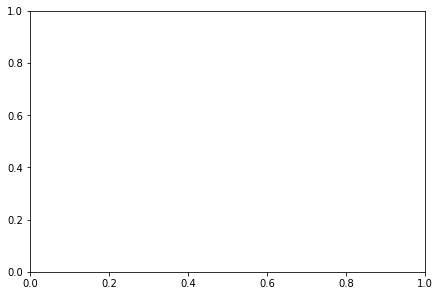

In [4]:
fig, ax = plt.subplots(constrained_layout=True)
ax.plot([i+1 for i in range(9)], test_scores[0], label = 'One layer')
ax.plot([i+1 for i in range(9)], test_scores[1], label = 'Ala LeNet')
ax.plot([i+1 for i in range(9)], test_scores[2], label = 'Ala Lenet with Relu')

ax.set_title("Plot of epochs and accuracy")
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()
plt.show()

In [7]:
dataset1 = datasets.FashionMNIST('data', train=True, transform=transform,download=True)
dataset2 = datasets.FashionMNIST('data', train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)
model = LeNet().to(device)
fashion_score = []
optimizer = optim.Adam(model.parameters())
scheduler = StepLR(optimizer, step_size=1)
for epoch in range(1, 20):
  train(args, model, device, train_loader, optimizer, epoch)
  test(model, device, test_loader,fashion_score)
  scheduler.step()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.309143
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.094053
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.661372
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.254269
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.093486
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.212413
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.000203
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.792248
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.973802
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.744613
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.789389
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.876738
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.690348
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.765541
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.711479
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.533100
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.613447
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.594799
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.727495
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.728451
Train Epoch: 1 [12800/60000 (

Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.512142
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.349774
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.593577
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.316771
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.349279
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.341218
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.294764
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.481110
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.385893
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.374138
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.556377
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.466731
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.378563
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.283236
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.336015
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.345818
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.320635
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.422411
Train Epoch: 2 [56960/60000 (95%)]	Loss: 0.613844
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.468638


Train Epoch: 4 [30720/60000 (51%)]	Loss: 0.458086
Train Epoch: 4 [31360/60000 (52%)]	Loss: 0.353469
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.450173
Train Epoch: 4 [32640/60000 (54%)]	Loss: 0.373524
Train Epoch: 4 [33280/60000 (55%)]	Loss: 0.367665
Train Epoch: 4 [33920/60000 (57%)]	Loss: 0.414811
Train Epoch: 4 [34560/60000 (58%)]	Loss: 0.440500
Train Epoch: 4 [35200/60000 (59%)]	Loss: 0.445199
Train Epoch: 4 [35840/60000 (60%)]	Loss: 0.490787
Train Epoch: 4 [36480/60000 (61%)]	Loss: 0.235210
Train Epoch: 4 [37120/60000 (62%)]	Loss: 0.197192
Train Epoch: 4 [37760/60000 (63%)]	Loss: 0.399179
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.315252
Train Epoch: 4 [39040/60000 (65%)]	Loss: 0.366997
Train Epoch: 4 [39680/60000 (66%)]	Loss: 0.578495
Train Epoch: 4 [40320/60000 (67%)]	Loss: 0.324269
Train Epoch: 4 [40960/60000 (68%)]	Loss: 0.258620
Train Epoch: 4 [41600/60000 (69%)]	Loss: 0.212039
Train Epoch: 4 [42240/60000 (70%)]	Loss: 0.474386
Train Epoch: 4 [42880/60000 (71%)]	Loss: 0.403571


Train Epoch: 6 [16000/60000 (27%)]	Loss: 0.471481
Train Epoch: 6 [16640/60000 (28%)]	Loss: 0.388965
Train Epoch: 6 [17280/60000 (29%)]	Loss: 0.537951
Train Epoch: 6 [17920/60000 (30%)]	Loss: 0.258894
Train Epoch: 6 [18560/60000 (31%)]	Loss: 0.306201
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.532719
Train Epoch: 6 [19840/60000 (33%)]	Loss: 0.431769
Train Epoch: 6 [20480/60000 (34%)]	Loss: 0.333140
Train Epoch: 6 [21120/60000 (35%)]	Loss: 0.371791
Train Epoch: 6 [21760/60000 (36%)]	Loss: 0.521498
Train Epoch: 6 [22400/60000 (37%)]	Loss: 0.379196
Train Epoch: 6 [23040/60000 (38%)]	Loss: 0.306562
Train Epoch: 6 [23680/60000 (39%)]	Loss: 0.275120
Train Epoch: 6 [24320/60000 (41%)]	Loss: 0.337862
Train Epoch: 6 [24960/60000 (42%)]	Loss: 0.239244
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.446976
Train Epoch: 6 [26240/60000 (44%)]	Loss: 0.423083
Train Epoch: 6 [26880/60000 (45%)]	Loss: 0.229088
Train Epoch: 6 [27520/60000 (46%)]	Loss: 0.227372
Train Epoch: 6 [28160/60000 (47%)]	Loss: 0.355661


Train Epoch: 8 [1280/60000 (2%)]	Loss: 0.253909
Train Epoch: 8 [1920/60000 (3%)]	Loss: 0.288289
Train Epoch: 8 [2560/60000 (4%)]	Loss: 0.427004
Train Epoch: 8 [3200/60000 (5%)]	Loss: 0.505557
Train Epoch: 8 [3840/60000 (6%)]	Loss: 0.475812
Train Epoch: 8 [4480/60000 (7%)]	Loss: 0.347554
Train Epoch: 8 [5120/60000 (9%)]	Loss: 0.332648
Train Epoch: 8 [5760/60000 (10%)]	Loss: 0.302939
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.569455
Train Epoch: 8 [7040/60000 (12%)]	Loss: 0.257451
Train Epoch: 8 [7680/60000 (13%)]	Loss: 0.325148
Train Epoch: 8 [8320/60000 (14%)]	Loss: 0.474964
Train Epoch: 8 [8960/60000 (15%)]	Loss: 0.195592
Train Epoch: 8 [9600/60000 (16%)]	Loss: 0.427954
Train Epoch: 8 [10240/60000 (17%)]	Loss: 0.268926
Train Epoch: 8 [10880/60000 (18%)]	Loss: 0.403182
Train Epoch: 8 [11520/60000 (19%)]	Loss: 0.265514
Train Epoch: 8 [12160/60000 (20%)]	Loss: 0.382880
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.517106
Train Epoch: 8 [13440/60000 (22%)]	Loss: 0.433733
Train Epoch: 8 [14080

Train Epoch: 9 [46720/60000 (78%)]	Loss: 0.665947
Train Epoch: 9 [47360/60000 (79%)]	Loss: 0.458371
Train Epoch: 9 [48000/60000 (80%)]	Loss: 0.426279
Train Epoch: 9 [48640/60000 (81%)]	Loss: 0.358426
Train Epoch: 9 [49280/60000 (82%)]	Loss: 0.497561
Train Epoch: 9 [49920/60000 (83%)]	Loss: 0.312960
Train Epoch: 9 [50560/60000 (84%)]	Loss: 0.453543
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.381441
Train Epoch: 9 [51840/60000 (86%)]	Loss: 0.252059
Train Epoch: 9 [52480/60000 (87%)]	Loss: 0.677269
Train Epoch: 9 [53120/60000 (88%)]	Loss: 0.347588
Train Epoch: 9 [53760/60000 (90%)]	Loss: 0.421059
Train Epoch: 9 [54400/60000 (91%)]	Loss: 0.480070
Train Epoch: 9 [55040/60000 (92%)]	Loss: 0.482915
Train Epoch: 9 [55680/60000 (93%)]	Loss: 0.380472
Train Epoch: 9 [56320/60000 (94%)]	Loss: 0.232599
Train Epoch: 9 [56960/60000 (95%)]	Loss: 0.334098
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.432725
Train Epoch: 9 [58240/60000 (97%)]	Loss: 0.304811
Train Epoch: 9 [58880/60000 (98%)]	Loss: 0.523668


Train Epoch: 11 [30080/60000 (50%)]	Loss: 0.334233
Train Epoch: 11 [30720/60000 (51%)]	Loss: 0.330010
Train Epoch: 11 [31360/60000 (52%)]	Loss: 0.390582
Train Epoch: 11 [32000/60000 (53%)]	Loss: 0.393115
Train Epoch: 11 [32640/60000 (54%)]	Loss: 0.418625
Train Epoch: 11 [33280/60000 (55%)]	Loss: 0.307126
Train Epoch: 11 [33920/60000 (57%)]	Loss: 0.424191
Train Epoch: 11 [34560/60000 (58%)]	Loss: 0.430315
Train Epoch: 11 [35200/60000 (59%)]	Loss: 0.252656
Train Epoch: 11 [35840/60000 (60%)]	Loss: 0.420626
Train Epoch: 11 [36480/60000 (61%)]	Loss: 0.361708
Train Epoch: 11 [37120/60000 (62%)]	Loss: 0.439112
Train Epoch: 11 [37760/60000 (63%)]	Loss: 0.372435
Train Epoch: 11 [38400/60000 (64%)]	Loss: 0.437290
Train Epoch: 11 [39040/60000 (65%)]	Loss: 0.413757
Train Epoch: 11 [39680/60000 (66%)]	Loss: 0.404604
Train Epoch: 11 [40320/60000 (67%)]	Loss: 0.478327
Train Epoch: 11 [40960/60000 (68%)]	Loss: 0.376122
Train Epoch: 11 [41600/60000 (69%)]	Loss: 0.385784
Train Epoch: 11 [42240/60000 (7

Train Epoch: 13 [12800/60000 (21%)]	Loss: 0.322850
Train Epoch: 13 [13440/60000 (22%)]	Loss: 0.349826
Train Epoch: 13 [14080/60000 (23%)]	Loss: 0.427956
Train Epoch: 13 [14720/60000 (25%)]	Loss: 0.217861
Train Epoch: 13 [15360/60000 (26%)]	Loss: 0.344002
Train Epoch: 13 [16000/60000 (27%)]	Loss: 0.270830
Train Epoch: 13 [16640/60000 (28%)]	Loss: 0.372526
Train Epoch: 13 [17280/60000 (29%)]	Loss: 0.251874
Train Epoch: 13 [17920/60000 (30%)]	Loss: 0.366783
Train Epoch: 13 [18560/60000 (31%)]	Loss: 0.426479
Train Epoch: 13 [19200/60000 (32%)]	Loss: 0.462379
Train Epoch: 13 [19840/60000 (33%)]	Loss: 0.415118
Train Epoch: 13 [20480/60000 (34%)]	Loss: 0.302377
Train Epoch: 13 [21120/60000 (35%)]	Loss: 0.549045
Train Epoch: 13 [21760/60000 (36%)]	Loss: 0.433866
Train Epoch: 13 [22400/60000 (37%)]	Loss: 0.226688
Train Epoch: 13 [23040/60000 (38%)]	Loss: 0.230871
Train Epoch: 13 [23680/60000 (39%)]	Loss: 0.297920
Train Epoch: 13 [24320/60000 (41%)]	Loss: 0.247273
Train Epoch: 13 [24960/60000 (4

Train Epoch: 14 [55680/60000 (93%)]	Loss: 0.402672
Train Epoch: 14 [56320/60000 (94%)]	Loss: 0.433928
Train Epoch: 14 [56960/60000 (95%)]	Loss: 0.484564
Train Epoch: 14 [57600/60000 (96%)]	Loss: 0.517321
Train Epoch: 14 [58240/60000 (97%)]	Loss: 0.256275
Train Epoch: 14 [58880/60000 (98%)]	Loss: 0.338439
Train Epoch: 14 [59520/60000 (99%)]	Loss: 0.259894


KeyboardInterrupt: 

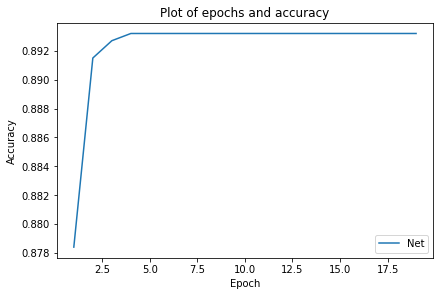

In [6]:
fig, ax = plt.subplots(constrained_layout=True)
ax.plot([i+1 for i in range(19)], fashion_score, label = 'Net')

ax.set_title("Plot of epochs and accuracy")
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()
plt.show()

In [ ]:
for data,target in test_loader:
    data, target = data.to(device), target.to(device)

    output = model(data)
    pred = output.argmax(dim=1, keepdim=True) 
    target = target.cpu()
    pred = pred.cpu()
    cm = confusion_matrix(target.view_as(pred),pred)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(dataset1.classes)))
    ax.set_xticklabels(dataset1.classes)
    ax.set_yticks(np.arange(len(dataset1.classes)))
    ax.set_yticklabels(dataset1.classes)
    plt.show()   

In [ ]:
data, target = data.to(device), target.to(device)
output = model(data)

In [ ]:
output[0]

In [ ]:
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)
images, labels = next(iter(test_loader))
plt.imshow(images[441].squeeze(),cmap='gray')

In [ ]:
labels[5521]

In [ ]:
def get_image(act, pred, act_pos, pred_pos):
    best_index = 0
    best_score = -1000000000000
    i=0
    for actual,predicted in zip(act,pred):
        if(actual.item()==act_pos and predicted.argmax()==pred_pos):
            if predicted.max().item() > best_score:
                best_score = predicted.max().item()
                best_index = i
        i+=1
    return best_index

In [ ]:
data, target = data.to(device), target.to(device)
output = model(data)
fig, ax = plt.subplots(nrows=10, ncols=10,sharex=True, sharey=True,figsize=(10,10))
ax = ax.flatten()
fig.frameon = False
for idx in range(10):    
    for jdx in range(10): 
        ax[idx*10+jdx].imshow(images[get_image(target,output,jdx,idx)].squeeze(), cmap='gray',aspect='equal')
        right_side = ax[idx*10+jdx].spines["right"]
        right_side.set_visible(False)
        ax[idx*10+jdx].axis('off')
    ax[idx].set_title(dataset1.classes[idx])